# CNN 모델
- 활용 데이터셋: Dogs & Cats

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import time
import zipfile
import matplotlib.pyplot as plt

## 0. 데이터 다운로드

In [2]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-08-27 15:27:29--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   103MB/s    in 0.6s    

2024-08-27 15:27:29 (103 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# zip 파일을 열고 압축된 파일을 data 폴더에 모두 추출
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("data/")
zip_ref.close()

# 기본 디렉토리 주소 설정
BASE_DIR = os.path.join('data', 'cats_and_dogs_filtered')

# 학습/검증 데이터 저장 디렉토리 경로 설정
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# 학습/검증 데이터 중 고양이/강아지 이미지가 저장된 디렉토리 경로 설정
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print(f"Contents of base directory: {os.listdir(BASE_DIR)}")
print(f"\nContents of train directory: {os.listdir(train_dir)}")
print(f"\nContents of validation directory: {os.listdir(validation_dir)}")

Contents of base directory: ['train', 'validation', 'vectorize.py']

Contents of train directory: ['cats', 'dogs']

Contents of validation directory: ['cats', 'dogs']


## 1. 하이퍼파라미터 설정

In [4]:
batch_size = 32
learning_rate = 0.003
epochs = 10
image_size = 224

In [5]:
# 데이터 증강 및 전처리
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)), # 이미지를 지정된 크기로 변경
    transforms.RandomHorizontalFlip(), # 이미지의 좌우를 랜덤하게 반전시켜 데이터 증강 효과
    transforms.ToTensor() # pytorch 텐서로 변환하고 [0, 1] 범위로 정규화
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
])

## 데이터로더 설정

In [6]:
path = os.path.join('data', 'cats_and_dogs_filtered')

train_dir = os.path.join(path, 'train')
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms) # train_dir 경로의 이미지에 train_transforms 전처리를 적용해 학습 데이터 셋 생성

valid_dir = os.path.join(path, 'validation')
valid_data = datasets.ImageFolder(root=valid_dir, transform=test_transforms) # valid_dir 경로의 이미지에 test_transforms 전처리를 적용해 검증 데이터 셋 생성

In [7]:
from torch.utils.data import random_split

# valid_data의 전체 크기를 계산
total_valid = len(valid_data)

# 검증 세트와 테스트 세트 크기 계산 (각각 절반씩)
valid_size = total_valid // 2
test_size = total_valid - valid_size  # 나머지 모든 이미지를 테스트 세트에 할당

# random_split을 사용하여 데이터 분할
valid_data, test_data = random_split(valid_data, [valid_size, test_size])

In [8]:
# 학습/검증/평가 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

print(f'train images: {len(train_loader.dataset)}')
print(f'valid images: {len(valid_loader.dataset)}')
print(f'test images: {len(test_loader.dataset)}')

train images: 2000
valid images: 500
test images: 500


## 이미지 체크

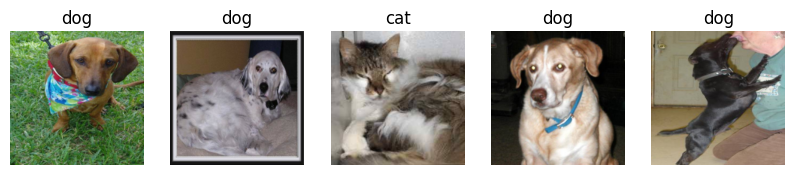

In [9]:
np.random.seed(42)
random_nums = [np.random.randint(1, 2001) for i in range(5)] # 1-2000 사이의 랜덤한 정수 5개 저장

plt.figure(figsize=(10, 2))

for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1) # 5번 번갈아가며 서브플롯 생성
    plt.imshow(np.transpose(train_loader.dataset[random_nums[i]][0], (1,2,0))) # 이미지 데이터를 (C, H, W)에서 (H, W, C) 차원으로 변환, 랜덤 번호의 이미지 출력
    plt.title(f'{"cat" if train_loader.dataset[random_nums[i]][1] == 0 else "dog"}') # 각 라벨을 가져와 라벨이 0이면 cat, 1이면 dog으로 제목 설정
    plt.axis('off')

In [10]:
next(iter(train_loader))[0].shape # 첫 번째 배치의 차원 확인 (batch_size, channel, height, width)

torch.Size([32, 3, 224, 224])

# CNN Modeling

In [16]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # torch.nn.Module을 상속받는 CNN 클래스 정의

        # 8개의 합성곱 블록 정의
        self.conv_block1, self.shape = self.conv_block(224, 3, 8, 3, padding=1) # 입력 이미지는 224x224, 3개의 채널로 8개의 출력 채널 생성
        self.conv_block2, self.shape = self.conv_block(self.shape, 8, 16, 3, stride=2) # 입력 채널 8개로 출력 채널 16개 생성, 출력의 크기가 절반으로 축소
        self.conv_block3, self.shape = self.conv_block(self.shape, 16, 16, 3, padding=1) # 출력 이미지 크기 동일
        self.conv_block4, self.shape = self.conv_block(self.shape, 16, 32, 3, stride=2)
        self.conv_block5, self.shape = self.conv_block(self.shape, 32, 32, 3, padding=1)
        self.conv_block6, self.shape = self.conv_block(self.shape, 32, 64, 3, stride=2)
        self.conv_block7, self.shape = self.conv_block(self.shape, 64, 64, 3, padding=1)
        self.conv_block8, self.shape = self.conv_block(self.shape, 64, 128, 3, stride=2)

        # 3개의 완전 연결 블록 정의
        self.fc_block1 = self.fc_block(128 * self.shape**2, 256) # 입력 뉴런 수는 합성곱 블록의 마지막 출력 크기 (128*13*13)
        self.fc_block2 = self.fc_block(256, 128)
        self.fc_block3 = self.fc_block(128, 32)

        self.output = torch.nn.Linear(32, 1) # 이진 분류

    # 합성곱 블록 정의 함수
    def conv_block(self, shape, in_, out_, kernel, stride= 1, padding=0):
        # 합성곱, 배치 정규화, ReLU 활성화 함수로 구성된 블록 생성
        block = torch.nn.Sequential(
        torch.nn.Conv2d(in_, out_, kernel, stride=stride, padding=padding, bias=False),
        torch.nn.BatchNorm2d(out_),
        torch.nn.ReLU()
        )

        shape = int(np.floor((shape - kernel + 2*padding) / stride) + 1 ) # 출력 크기 계산

        return block, shape

    # 완전 연결 블록 정의 함수
    def fc_block(self, in_, out_):
        # 선형 변환, 배치 정규화, ReLU 활성화 함수로 구성된 블록 생성
        block = torch.nn.Sequential(
        torch.nn.Linear(in_, out_, bias=False),
        torch.nn.BatchNorm1d(out_),
        torch.nn.ReLU()
        )
        return block

    # 순전파 함수 정의
    def forward(self, x):
        # (1, 224, 224)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.conv_block7(x)
        x = self.conv_block8(x)

        x = torch.flatten(x, 1) # 합성곱 블록의 출력을 평탄화하여 1차원 텐서로 변환
        # x = x.view(-1, 64 * self.shape**2)

        x = self.fc_block1(x)
        x = self.fc_block2(x)
        x = self.fc_block3(x)

        x = self.output(x)
        x = torch.sigmoid(x) # 이진 분류 문제이므로 sigmoid 함수 적용

        return x

# Loss Function & Optimizer 설정

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [18]:
model = CNN().to(device)
loss_func = nn.BCELoss() # 이진 분류 문제에 적합한 손실함수
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchN

# Train

In [19]:
def evaluate(model, loader):
    model.eval() # 모델을 평가모드로 전환(dropout, batch norm 비활성화)
    eval_loss = 0.0
    eval_acc = 0.0

    with torch.no_grad(): # 평가 시에는 gradient를 계산하지 않기 위해 no_grad 블록 사용해 메모리 사용량을 줄이고 연산 속도를 높임

        for image, label in loader: # 데이터 로더에서 배치를 하나씩 가져와 평가

            image = image.to(device)
            label = label.to(device).view(32, -1).float() # (32x1) 크기로 변환
            pred = model(image) # 모델에 이미지를 입력하여 예측값을 얻음

            eval_loss += criterion(pred, label).item() # 예측값과 실제 라벨 간의 손실을 계산하여 평가 손실에 누적

            label_pred = pred.round() # 예측값을 0 또는 1로 반올림하여 클래스 예측 결과 산출
            eval_acc += (label == label_pred).sum() # 실제 라벨과 예측된 라벨의 일치도 계산해 정확도에 누적

    # 전체 데이터 셋에 대한 평균 손실/정확도 계산
    eval_loss = eval_loss / len(loader)
    eval_acc = eval_acc / len(loader.dataset)

    return eval_loss, eval_acc

In [23]:
def train(model, epochs):

    global criterion, pred, label_pred, label # 전역 변수 선언 (주로 디버깅 목적)

    # 손실함수
    criterion = torch.nn.BCELoss()
    # 옵티마이저
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    losses = {'train_loss': [],
              'train_acc': [],
              'val_loss': [],
              'val_acc': []}

    for epoch in range(epochs):
        print('Epoch: {:0>4}...'.format(epoch+1), end='\t')

        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        running_acc = 0

        for i, (image, label) in enumerate(train_loader): # 학습 데이터 로더에서 배치를 하나씩 가져와 학습

            image = image.to(device)
            label = label.to(device).view(32, -1).float()

            # 변화도 초기화
            optimizer.zero_grad()

            #예측
            pred = model(image)

            #손실계산
            loss = criterion(pred, label)

            #정확도 계산
            label_pred = pred.round()
            running_acc += (label == label_pred).sum()

            #역전파
            loss.backward()

            #가중치 갱신
            optimizer.step()

            #손실값 갱신
            running_loss += loss.item()


        # 학습성능 확인
        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader.dataset)

        losses['train_loss'].append(train_loss)
        losses['train_acc'].append(train_acc)

        print('train_loss: {:.4f}'.format(train_loss), end='\t')
        print('train_acc: {:.4f}'.format(train_acc), end='\t\t')

        # 검증성능 확인
        val_loss, val_acc = evaluate(model, valid_loader)

        losses['val_loss'].append(val_loss)
        losses['val_acc'].append(val_acc)

        print('val_loss: {:.4f}'.format(val_loss), end='\t')
        print('val_acc: {:.4f}'.format(val_acc))
        print()

    return losses

In [21]:
model = CNN().to(device)
losses = train(model, 20)

Epoch: 0001...	train_loss: 0.6940	train_acc: 0.5420		val_loss: 0.6946	val_acc: 0.5480

Epoch: 0002...	train_loss: 0.6848	train_acc: 0.5415		val_loss: 0.6920	val_acc: 0.5080

Epoch: 0003...	train_loss: 0.6586	train_acc: 0.6160		val_loss: 0.6414	val_acc: 0.5780

Epoch: 0004...	train_loss: 0.6420	train_acc: 0.6280		val_loss: 0.6436	val_acc: 0.5920

Epoch: 0005...	train_loss: 0.6167	train_acc: 0.6595		val_loss: 0.6112	val_acc: 0.6360

Epoch: 0006...	train_loss: 0.5792	train_acc: 0.7010		val_loss: 0.7839	val_acc: 0.5720

Epoch: 0007...	train_loss: 0.5879	train_acc: 0.6905		val_loss: 0.6178	val_acc: 0.6340

Epoch: 0008...	train_loss: 0.5750	train_acc: 0.7005		val_loss: 0.6061	val_acc: 0.6360

Epoch: 0009...	train_loss: 0.5482	train_acc: 0.7220		val_loss: 0.6383	val_acc: 0.6180

Epoch: 0010...	train_loss: 0.5160	train_acc: 0.7470		val_loss: 0.6162	val_acc: 0.6140

Epoch: 0011...	train_loss: 0.5048	train_acc: 0.7455		val_loss: 0.6286	val_acc: 0.6260

Epoch: 0012...	train_loss: 0.4757	train_acc

## 결과 시각화

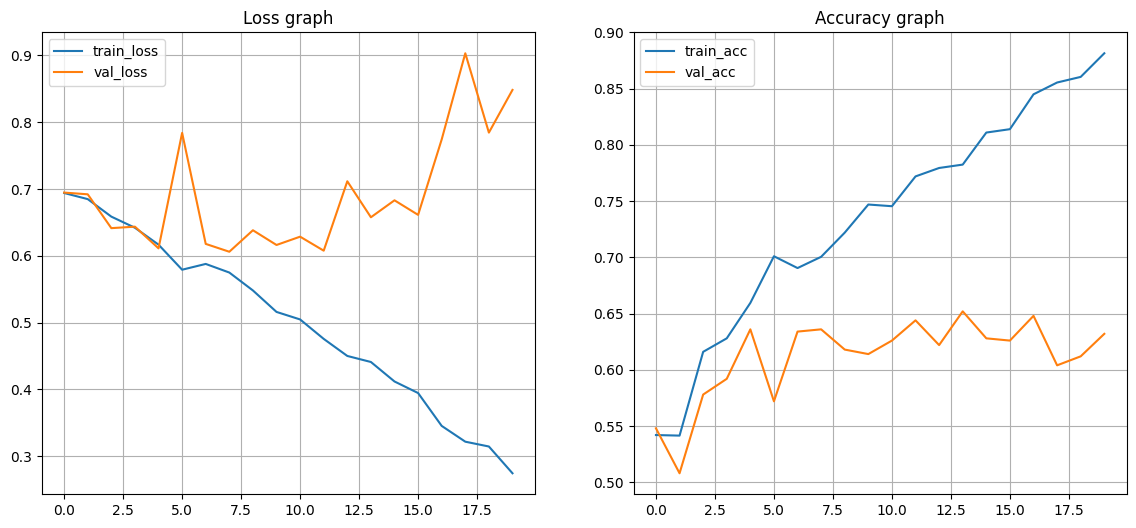

In [22]:
plt.figure(figsize=(14, 6))
plt.set_cmap('Paired')
plt.subplot(1, 2, 1)
plt.plot(losses['train_loss'], label='train_loss')
plt.plot(losses['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)
plt.title('Loss graph')

plt.subplot(1, 2, 2)
train_acc_cpu = torch.tensor([t.cpu().item() for t in losses['train_acc']])
val_acc_cpu = torch.tensor([t.cpu().item() for t in losses['val_acc']])
plt.plot(train_acc_cpu, label='train_acc')
plt.plot(val_acc_cpu, label='val_acc')
plt.legend()
plt.grid(True)
plt.title('Accuracy graph')

plt.show()

----